<font color="blue">Владимир, привет. Давай смотреть твой отчёт.

# Проект по прогнозированию оттока клиентов телеком

## Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Установка параметров

In [1]:
#Путь к датасетам
path = 'C:\\Users\\vovlo\\yandex-praktikum-projects\\yandex.practikum\\YandexPraktikum\\project_17_Graduation project\\'

In [2]:
#path ='/datasets/final_provider/'

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
from scipy import stats as st
from IPython.display import display # Для корректного формата вывода таблиц
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [4]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.utils import shuffle

import itertools
import operator

import warnings
warnings.filterwarnings('ignore')

## Предварительный анализ

In [5]:
data_name = ['contract.csv', 'personal.csv', 'internet.csv', 'phone.csv']

contract = pd.read_csv(path + data_name[0], index_col=[0], parse_dates=[1,2])
personal = pd.read_csv(path + data_name[1],index_col=[0])
internet = pd.read_csv(path + data_name[2],index_col=[0])
phone = pd.read_csv(path + data_name[3],index_col=[0])

tables = {'contract': contract, 'personal': personal, 'internet': internet, 'phone': phone}

In [6]:
for table in tables.values():
    display(table.head())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [7]:
for table in tables:
    print(table, tables[table].shape)
    #print(all_data[i].info())
    print()

contract (7043, 7)

personal (7043, 4)

internet (5517, 7)

phone (6361, 1)



## 1 Анализ `Contract`

Произведём корректировку типов данных:

In [8]:
tables['contract']['BeginDate'] = pd.to_datetime(tables['contract'].BeginDate, format='%Y.%m.%d')
tables['contract']['TotalCharges'] = pd.to_numeric(tables['contract']['TotalCharges'], errors='coerce' )
tables['contract'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 440.2+ KB


In [9]:
#Заменим пропуски на нули
tables['contract'].TotalCharges.fillna(0, inplace=True)
display(tables['contract'][tables['contract'].TotalCharges == 0])


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0


In [10]:
#Восстановим значения на основе столбца MonthlyCharges
tables['contract'].TotalCharges = tables['contract']\
.apply(lambda row: row['MonthlyCharges'] if row['TotalCharges'] == 0 else row['TotalCharges'], axis=1)

#Проверка
if tables['contract'][tables['contract'].TotalCharges.isnull() == True].count().sum() == 0:
    print('пропуски обработаны\n\n')
else:
    print('обнаружены пропуски, требуется провести анализ\n\n')
    
tables['contract'].info()

пропуски обработаны


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 440.2+ KB


В ячейке выше была произведенна замена пустых значений в признаке `TotalCharges` на значения из признака `MonthlyCharges`. Данная замена корректна, т.к. суммарный платеж аккумулирует в себе месячную плату и другие дополнительные услуги, в данном случае срез базы был произведен раньше чем прошёл месяц с момента заключения контракта клиентами, поэтому система не произвела суммирование в тотал.

In [11]:
tables['contract']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45


In [12]:
actual_contract = tables['contract'].query('EndDate == "No"')
no_actual_contract = tables['contract'].query('EndDate != "No"')
display(actual_contract.head(2))
display(no_actual_contract.head(2))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [13]:
no_actual_contract['EndDate'] = pd.to_datetime(no_actual_contract.EndDate, format='%Y.%m.%d')
no_actual_contract['diff'] = no_actual_contract.EndDate - no_actual_contract.BeginDate
#no_actual_contract.info()
no_actual_contract.sort_values(by='BeginDate', ascending=True)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,diff
customerID,,,,,,,,
2889-FPWRM,2013-10-01,2019-10-01,One year,Yes,Bank transfer (automatic),117.80,8684.80,2191 days
0917-EZOLA,2013-10-01,2019-10-01,Two year,Yes,Bank transfer (automatic),104.15,7689.95,2191 days
8580-QVLOC,2013-10-01,2019-10-01,Two year,No,Credit card (automatic),92.45,6440.25,2191 days
7317-GGVPB,2013-11-01,2019-10-01,Two year,Yes,Credit card (automatic),108.60,7690.90,2160 days
2834-JRTUA,2013-11-01,2019-10-01,Two year,Yes,Electronic check,108.05,7532.15,2160 days
...,...,...,...,...,...,...,...,...
3803-KMQFW,2019-12-01,2020-01-01,Month-to-month,No,Mailed check,20.55,20.55,31 days
0328-GRPMV,2019-12-01,2020-01-01,Month-to-month,Yes,Electronic check,70.10,70.10,31 days
2619-WFQWU,2019-12-01,2020-01-01,Month-to-month,Yes,Mailed check,70.15,70.15,31 days


Признак `diff` - показывает срок жизни клиента, получен по производной таблице `contract` на основе абонентов, которые покинули нас по тем или иным причинам.

In [14]:
#Скорректируем тип
no_actual_contract['diff'] = no_actual_contract['diff'].dt.days.astype('int')

Month-to-month    1655
One year           166
Two year            48
Name: Type, dtype: int64

Yes    1400
No      469
Name: PaperlessBilling, dtype: int64

Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: PaymentMethod, dtype: int64

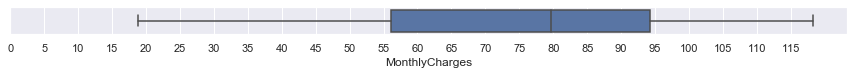

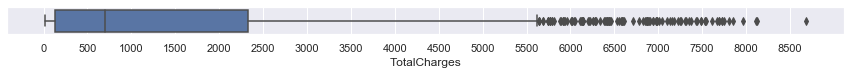

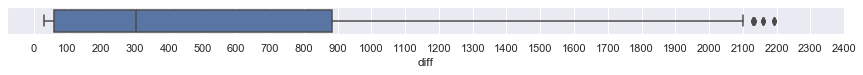

In [15]:
display(no_actual_contract['Type'].value_counts())
display(no_actual_contract['PaperlessBilling'].value_counts())
display(no_actual_contract['PaymentMethod'].value_counts())


plt.figure(figsize=(15,.5))
sns.boxplot(no_actual_contract['MonthlyCharges'])
plt.xticks(ticks=[x for x in range(0,120,5)]);
plt.show()

plt.figure(figsize=(15,.5))
sns.boxplot(no_actual_contract['TotalCharges'])
plt.xticks(ticks=[x for x in range(0,9000,500)]);
plt.show()

plt.figure(figsize=(15,.5))
sns.boxplot(no_actual_contract['diff'])
plt.xticks(ticks=[x for x in range(0,2500,100)]);
plt.show()

Возможна наблюдается мультиколлинеарность, поэтому проведем проверку на корреляцию между месячной и итоговой оплатой

In [16]:
np.corrcoef(tables['contract'].TotalCharges, tables['contract'].MonthlyCharges)

array([[1.        , 0.65118199],
       [0.65118199, 1.        ]])

Наблюдается средняя корреляция, но т.к. значение не более 0.8, то избыточный признак не критичен, но сет данных обладает избыточностью. Избыточный признак в данном случае `MonthlyCharges`. Поле получения результата нужно проверить насколько изменятся целевые метрики и после этого принимать решение об его удаление из сета.

In [17]:
print('Доля ушедших клиентов {:.2%}'.format(no_actual_contract.shape[0]/tables['contract'].shape[0]))

Доля ушедших клиентов 26.54%


In [18]:
no_actual_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1869 entries, 3668-QPYBK to 8361-LTMKD
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         1869 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              1869 non-null   object        
 3   PaperlessBilling  1869 non-null   object        
 4   PaymentMethod     1869 non-null   object        
 5   MonthlyCharges    1869 non-null   float64       
 6   TotalCharges      1869 non-null   float64       
 7   diff              1869 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(3)
memory usage: 124.1+ KB


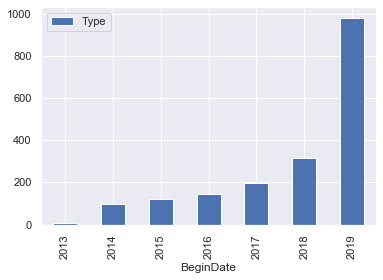

In [19]:
(no_actual_contract
 .pivot_table(index=[no_actual_contract['BeginDate'].dt.year],
              values='Type', aggfunc='count')).plot(kind='bar');

#,no_actual_contract['BeginDate'].dt.month

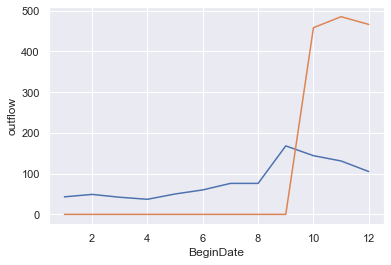

In [20]:
temp = (no_actual_contract
 .pivot_table(index=[no_actual_contract['BeginDate'].dt.month[no_actual_contract['BeginDate'].dt.year == 2019]],
                    #no_actual_contract['BeginDate'].dt.month],
              values='Type', aggfunc='count'))
#temp.index.name = ['year','month']
temp['outflow'] = 0
temp['outflow'][10] = 458
temp['outflow'][11] = 485
temp['outflow'][12] = 466
temp.columns = ['inflow','outflow']
temp
#.plot(kind='bar')
#plt.show()

#(no_actual_contract
# .pivot_table(index=[no_actual_contract['EndDate'].dt.year,no_actual_contract['EndDate'].dt.month],
#              values='Type', aggfunc='count')).plot(kind='bar')
sns.lineplot(y=temp.inflow , x=temp.index);
sns.lineplot(y=temp.outflow , x=temp.index);

#plt.show()

In [21]:
temp.outflow.mean()*80

9393.333333333334

In [22]:
(no_actual_contract
 .pivot_table(index=[no_actual_contract['EndDate'].dt.year,no_actual_contract['EndDate'].dt.month],
              values='Type', aggfunc='count'))#.plot(kind='bar')

Type
EndDate EndDate      
2019    10        458
        11        485
        12        466
2020    1         460

In [23]:
print('min_date', tables['contract']['BeginDate'].min())
print('max_date', tables['contract']['BeginDate'].max(), '- дата выгрузки')
print('delta', no_actual_contract['EndDate'].max() - tables['contract']['BeginDate'].min())

min_date 2013-10-01 00:00:00
max_date 2020-02-01 00:00:00 - дата выгрузки
delta 2283 days 00:00:00


## Вывод по таблице `Contract`
Клиенты начали уходить 4 месяца назад от даты выгрузки, на текущий момент ушло 26,5% клиентов,г8де ежемесячно уходит порядка 450 клиентов и ежемесячный убыток идёт накопительным итогом, где на октябрь потери составили порядка 9 тысяч, затем на ноябрь 18 тысяч и декабрь 27 тысяч, а количество новых клиентов уменьшается и если в январе 2020 года утечка клиентов сохранилась на среднем значении порядка 450, то новые клиенты осутствуют полностью. 


## 2 Анализ `Personal`

In [24]:
tables.keys()

dict_keys(['contract', 'personal', 'internet', 'phone'])

In [25]:
tables['personal'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [26]:
len(tables['personal'].index.unique())

7043

In [27]:
list(tables['personal'].columns)

['gender', 'SeniorCitizen', 'Partner', 'Dependents']

In [28]:
for i in range(tables['personal'].shape[1]):
    print(tables['personal'].iloc[:,i].value_counts())
    print()

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64



## Вывод по таблице `Personal`
Признаки: `'gender'`, `'SeniorCitizen'`, `'Partner'`, `'Dependents'` - являются булевыми. Требуется заменить значения признаков на 1 и 0. Пропусков и других анамалий не обнаружено.


---

## 3 Анализ `Internet`

In [29]:
tables['internet'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [30]:
#проверим уникальность 
len(tables['internet'].index.unique())

5517

In [31]:
tables['internet'].sample(8)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
9500-LTVBP,Fiber optic,No,No,No,Yes,No,No
5949-HGVJL,DSL,No,Yes,No,Yes,Yes,Yes
2550-AEVRU,DSL,Yes,Yes,No,No,No,No
8871-JLMHM,Fiber optic,No,Yes,Yes,Yes,No,No
6686-YPGHK,Fiber optic,Yes,No,No,No,No,Yes
9117-SHLZX,DSL,No,No,No,No,No,No
1262-OPMFY,Fiber optic,No,No,Yes,No,No,No
1956-YIFGE,Fiber optic,No,Yes,Yes,No,Yes,Yes


In [32]:
for i in range(tables['internet'].shape[1]):
    print(tables['internet'].iloc[:,i].value_counts())
    print()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

No     3473
Yes    2044
Name: TechSupport, dtype: int64

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



## Вывод по таблице `Internet`
Признаки бинарны. Проблем не обнаружено.


---

## 4 Анализ `Phone`


In [33]:
tables['phone'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [34]:
tables['phone'].sample(3)

,MultipleLines
customerID,
6260-XLACS,No
7321-PKUYW,Yes
3090-HAWSU,Yes


In [35]:
tables['phone']['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

## Вывод по таблице `Phone`
Признаки бинарны. Проблем не обнаружено.


## Соединим все таблицы в общую

In [36]:
tables.keys()

dict_keys(['contract', 'personal', 'internet', 'phone'])

In [37]:
display(tables['contract'].head(2))
display(tables['phone'].head(2))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No


In [38]:
frames = [tables['contract'], tables['personal'], tables['internet'], tables['phone']]

result = pd.concat(frames, axis=1)
result.sample(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
8259-DZLIZ,2014-10-01,No,One year,Yes,Bank transfer (automatic),53.85,3399.85,Female,0,Yes,Yes,DSL,No,Yes,No,No,No,No,Yes
4248-HCETZ,2017-04-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,79.65,2365.15,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,No,No,No
7315-WYOAW,2019-01-01,No,Month-to-month,No,Electronic check,100.75,1313.25,Male,0,No,No,Fiber optic,No,No,No,Yes,Yes,Yes,Yes
9588-YRFHY,2016-01-01,No,Two year,Yes,Credit card (automatic),19.90,1022.60,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3096-YXENJ,2014-09-01,No,Two year,Yes,Bank transfer (automatic),107.65,7082.85,Female,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
7554-AKDQF,2019-08-01,No,Month-to-month,No,Mailed check,45.65,323.45,Female,0,Yes,No,DSL,No,No,No,No,No,No,No
4742-TXUEX,2016-03-01,No,Two year,No,Bank transfer (automatic),19.30,890.50,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7105-MXJLL,2017-12-01,No,One year,No,Mailed check,60.70,1597.40,Female,1,Yes,No,DSL,No,No,Yes,No,No,Yes,No
7876-DNYAP,2014-05-01,No,Two year,No,Credit card (automatic),19.80,1436.95,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5753-QQWPW,2017-10-01,No,One year,Yes,Electronic check,59.90,1654.70,Female,0,No,No,DSL,Yes,Yes,No,Yes,No,No,No


In [39]:
result.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Так как клиенты не пользовались интернетом, то в датафрейме `Internet` нет данных о них и вследствие объединения таблиц образовались пропуски, которые нужно заполнить значение `No`

In [40]:
result['InternetService'].fillna('not internet', inplace = True)
for i in tables['internet'].columns:
    if i == 'InternetService':
        pass
    else:
        result[i].fillna('No', inplace = True)
result['MultipleLines'].fillna('No', inplace = True)
result.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [41]:
result.sample(2)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0310-MVLET,2014-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,99.15,6010.05,Female,0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes
8993-PHFWD,2019-10-01,2020-01-01 00:00:00,Month-to-month,No,Electronic check,25.25,58.90,Female,0,No,No,DSL,No,No,No,No,No,No,No


### Заполним время ЖЦ контракта

In [42]:
result = (pd.concat([result, no_actual_contract['diff']], axis=1))

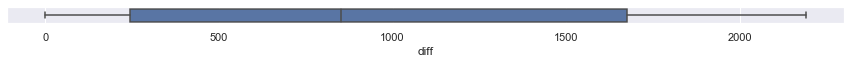

In [43]:
result['diff'] = abs(result['diff'].fillna(abs((no_actual_contract['EndDate'].max() - result['BeginDate']).dt.days.astype('int'))))
plt.figure(figsize=(15,.3))
sns.boxplot(result['diff']);

In [44]:
result['diff'].describe()

count    7043.000000
mean      963.319466
std       742.745158
min         0.000000
25%       245.000000
50%       852.000000
75%      1675.000000
max      2191.000000
Name: diff, dtype: float64

In [45]:
def func(row):
    if row.EndDate == "No":
        return 0
    else:
        return 1
        
result['target'] = 1
result['target'] = result.apply(func, axis=1) 
gone = result.query('EndDate != "No"')
left = result.query('EndDate == "No"')
del gone['BeginDate']
del gone['EndDate']
del left['BeginDate']
del left['EndDate']

## Задача 1
Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга «Ниединогоразрыва.ком» приступает к проработке способов их удержания. Вам предстоит собрать нужную для этого информацию.~
Сравните распределения величин ежемесячных платежей (`MonthlyCharges`) всех действующих клиентов и тех, кто ушёл.
* Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.
* Постройте гистограммы распределения.

Сравните поведение клиентов этих двух групп. Для каждой постройте два любых графика, изображающих:
* долю пользователей телефонной связи;
* долю интернет-пользователей.

Month-to-month    1655
One year           166
Two year            48
Name: Type, dtype: int64

Yes    1400
No      469
Name: PaperlessBilling, dtype: int64

Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: PaymentMethod, dtype: int64

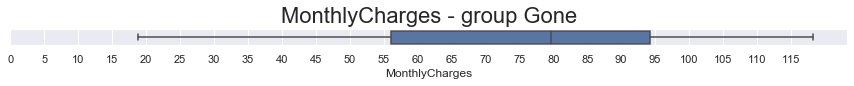

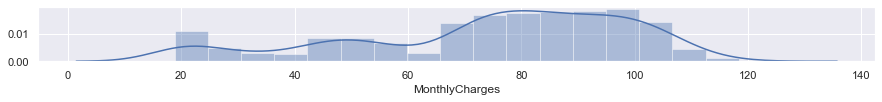

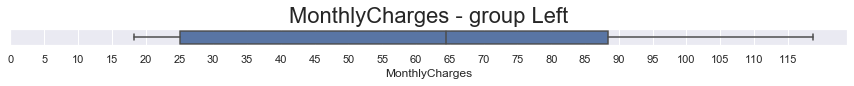

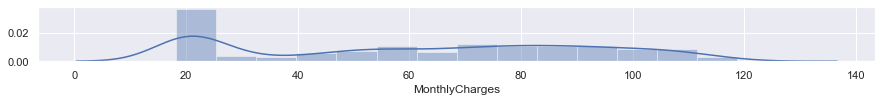

In [46]:
display(gone['Type'].value_counts())
display(gone['PaperlessBilling'].value_counts())
display(gone['PaymentMethod'].value_counts())

def draw_boxplot(table, column, titles, xtick_end, xtick_step):
    plt.figure(figsize=(15,.3))
    plt.title(titles, fontsize=22)
    sns.boxplot(table[column])
    plt.xticks(ticks=[x for x in range(0,xtick_end, xtick_step)]);
    plt.show()
    plt.figure(figsize=(15,1))
    sns.distplot(table[column])
    
draw_boxplot(gone, 'MonthlyCharges', "MonthlyCharges - group Gone", 120, 5)
draw_boxplot(left, 'MonthlyCharges', "MonthlyCharges - group Left", 120, 5)

* Ежемесячные плажежи в среднем выше у ушедших клиентов, также основное количество клиентов распределённое между 25 и 75 персентилями приносит более высокую оплату, а оставшиеся клиенты приносят более низную оплату и диапозон 25-75 персентиль охватывает от 25 до 90 рублей, что существенно ниже, также смещена медиана отностильно среднего значения.

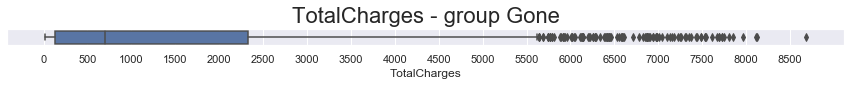

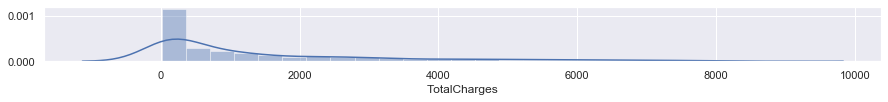

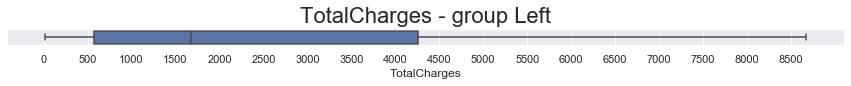

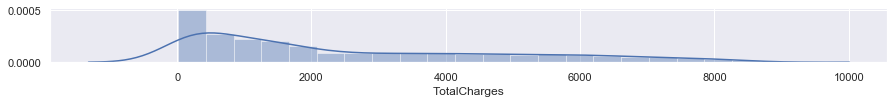

In [47]:
draw_boxplot(gone, 'TotalCharges', "TotalCharges - group Gone", 9000, 500)
draw_boxplot(left, 'TotalCharges', "TotalCharges - group Left", 9000, 500)

* суммарные платежи выше у оставшихся клиентов, что очевидно, т.к. клиенты которые дольше всех находились в компании приносят больший ей доход. 

In [48]:
gone['diff'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: diff, dtype: float64

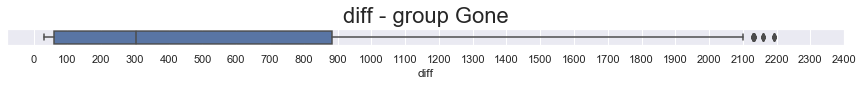

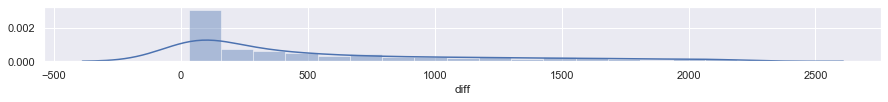

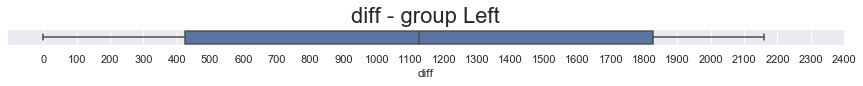

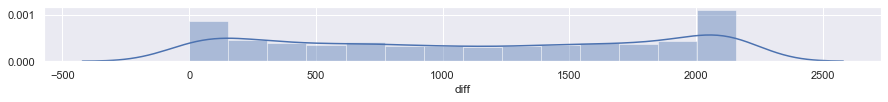

In [49]:
draw_boxplot(gone, 'diff', "diff - group Gone", 2500, 100)
draw_boxplot(left, 'diff', "diff - group Left", 2500, 100)

* Важный момент, что большинство клиентов, которые ушли пользовались услугами по медиане около 300 дней (есть расхождение со среднем значением,т.к. оно смещенно в большую сторону). Большинство клиентов порядка 64%, которые ушли, были в компании  были в ней от 61 до 883 дней, что означает, что данные клиенты были в ней не столь продолжительный преиод времени по сравнению с клиентами, которые оставлись и это в своем большинстве клиенты пользующиеся услугами не один год. Но т.к. прошло всего четыре месяца с момента появления конкурента и ежемесячный отток на уровне 400 человек, есть вероятность, что и остальные клиенты, которые любят провайдера могут уйти, необходимо срочно пересматривать макетинговую стратегию.

In [50]:
result[['BeginDate','EndDate', 'target']]

,BeginDate,EndDate,target
7590-VHVEG,2020-01-01,No,0
5575-GNVDE,2017-04-01,No,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,1
7795-CFOCW,2016-05-01,No,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,1
...,...,...,...
6840-RESVB,2018-02-01,No,0
2234-XADUH,2014-02-01,No,0
4801-JZAZL,2019-03-01,No,0
8361-LTMKD,2019-07-01,2019-11-01 00:00:00,1


In [51]:
gone.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,diff,target
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61.0,1
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61.0,1
9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,245.0,1
7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,853.0,1
0280-XJGEX,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1491.0,1


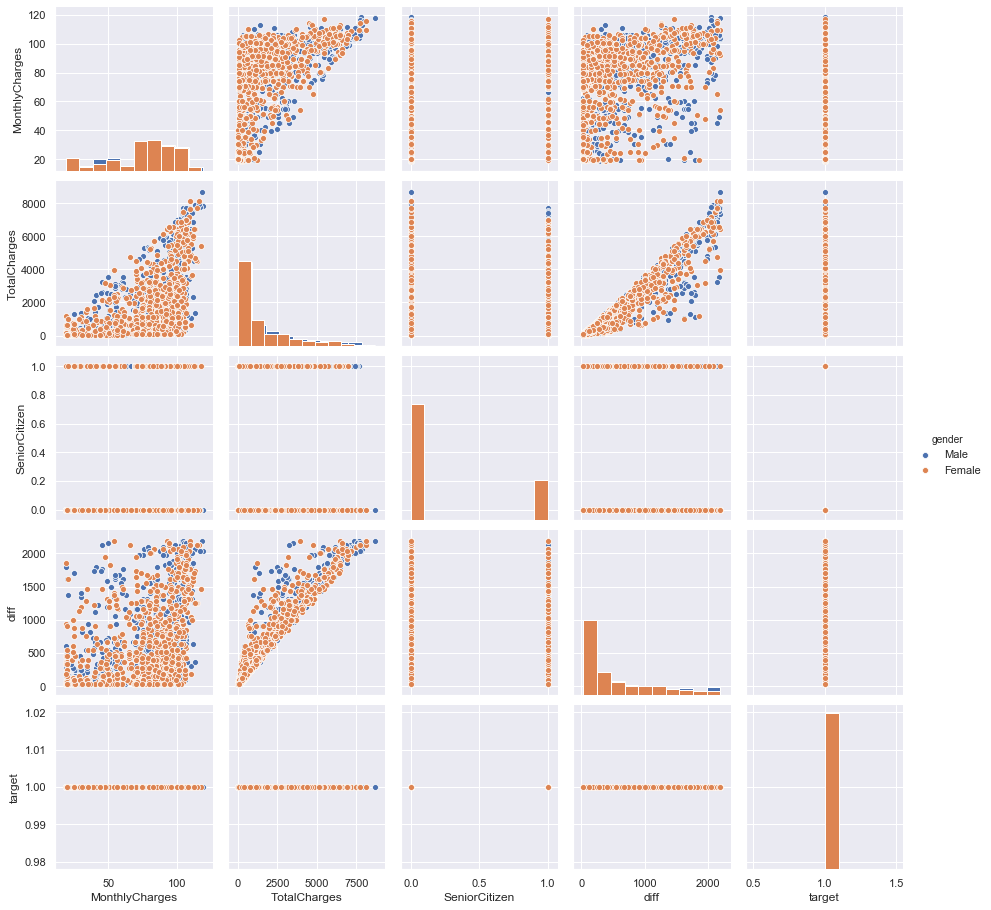

In [52]:
sns.pairplot(gone, hue='gender', diag_kind='hist');

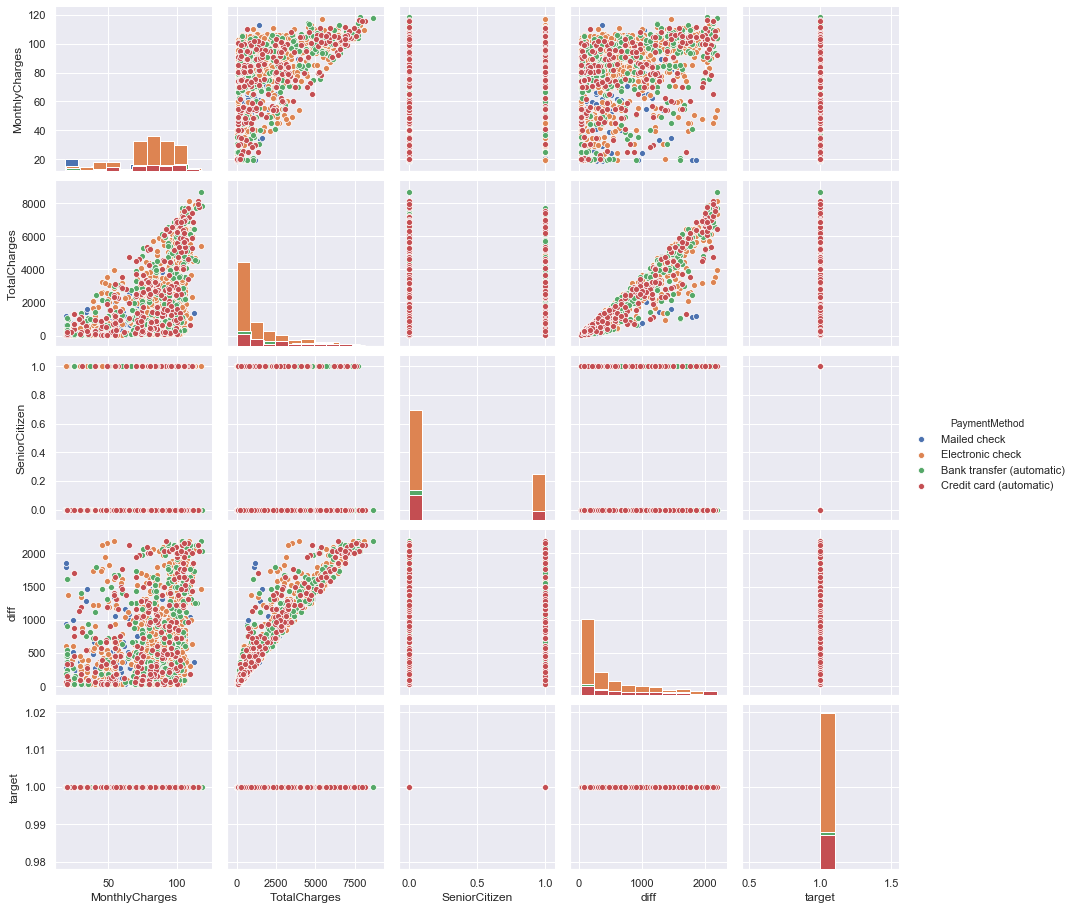

In [53]:
sns.pairplot(gone, hue='PaymentMethod', diag_kind='hist');

Данные графики малоинформативны, необходимо строить более детальный график. Стоит заметить что срок жизни  клиентов коррелирует с суммарными платежами.

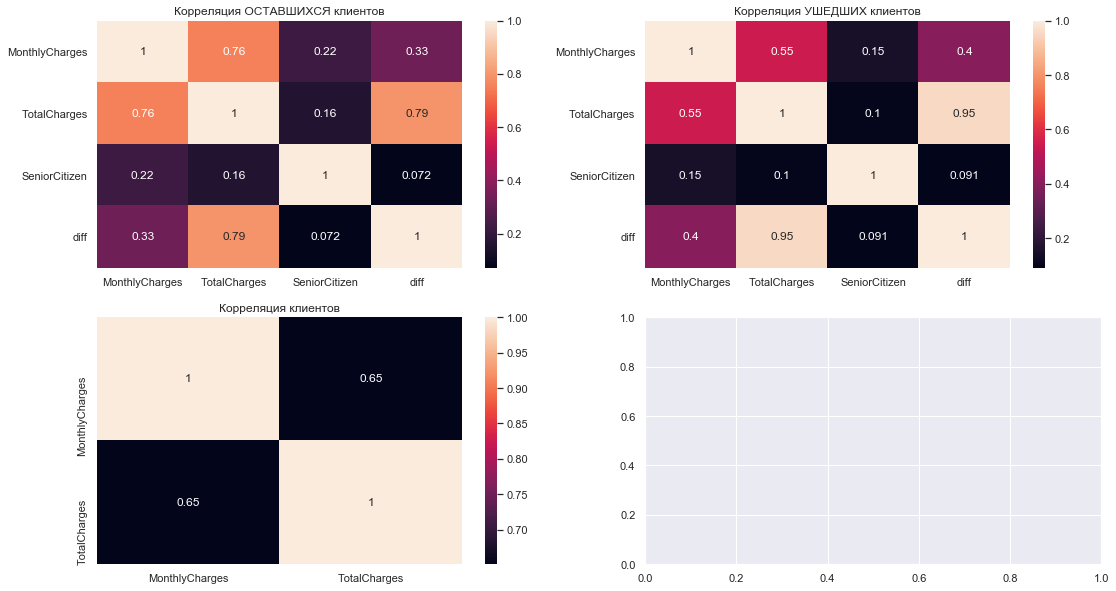

In [54]:
fig, axis = plt.subplots(2,2, figsize=(18,10))
q = sns.heatmap(left.corr().drop('target', axis = 1).drop('target', axis = 0).astype('float64'), annot=True,ax=axis[0,0]);
q.title.set_text('Корреляция ОСТАВШИХСЯ клиентов')

w = sns.heatmap(gone.corr().drop('target', axis = 1).drop('target', axis = 0).astype('float64'), annot=True,ax=axis[0,1]);
w.title.set_text('Корреляция УШЕДШИХ клиентов')

e = sns.heatmap(tables['contract'].corr(), annot=True,ax=axis[1,0])
e.title.set_text('Корреляция клиентов')

Признак ЖЦ клиента можно использовать и нужно для анализа, но его нельзя использовать для обучения моделей, т.к. у него высокая корелляция Пирсона с суммарными платежами, т.о. предлагается убрать данный столбец и проверить качество модели по метрикам.

### Избавимся от утечки целевого признака

In [55]:
del result['BeginDate']
del result['EndDate']
result

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,diff,target
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0.0,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1005.0,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61.0,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1340.0,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,699.0,0
2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2160.0,0
4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,306.0,0
8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,123.0,1


Подготовительные работы выполненны

----

# План работы
1. Привести таблицу к формату для работы моделей:
    * Произвести кодировку категориальных переменных
    * Произвести масшабирование признаков оплаты - дискретные значения. 
    * Проверить нет ли сильных корреляционных связей
2. Протестировать основные модели
    * Логическая регрессия
    * Random Forest Classifier
    * SVM
    * Бустинги
3. Выявить наиболее быстрые иснструменты и произвести тюнинг.

## Подготовка сета

In [56]:
display(result.sample(3))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,diff,target
9943-VSZUV,Month-to-month,Yes,Mailed check,75.70,5060.85,Male,1,No,No,Fiber optic,No,No,No,No,No,No,Yes,2010.0,0
2200-DSAAL,Two year,Yes,Electronic check,80.65,5330.20,Female,0,No,No,DSL,No,Yes,Yes,No,Yes,Yes,Yes,2040.0,0
4767-HZZHQ,Month-to-month,No,Bank transfer (automatic),82.05,2570.20,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,No,883.0,0


In [57]:
result = result.replace('Yes', 1)
result = result.replace('No', 1)
result = result.replace('Male', 1)
result = result.replace('Female', 0)
display(result.sample(3))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,diff,target
0052-YNYOT,One year,1,Electronic check,20.55,1343.40,0,0,1,1,not internet,1,1,1,1,1,1,1,2010.0,0
4094-NSEDU,Month-to-month,1,Electronic check,94.25,1973.75,0,1,1,1,Fiber optic,1,1,1,1,1,1,1,640.0,1
8970-ANWXO,One year,1,Mailed check,73.75,1756.60,0,0,1,1,DSL,1,1,1,1,1,1,1,671.0,0


In [58]:
binary_column = ['PaperlessBilling','gender','SeniorCitizen','Partner','Dependents','OnlineSecurity',\
                 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',\
                 'MultipleLines', 'target']

result[binary_column] = result[binary_column].astype('uint8')

In [59]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   uint8  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   uint8  
 6   SeniorCitizen     7043 non-null   uint8  
 7   Partner           7043 non-null   uint8  
 8   Dependents        7043 non-null   uint8  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   uint8  
 11  OnlineBackup      7043 non-null   uint8  
 12  DeviceProtection  7043 non-null   uint8  
 13  TechSupport       7043 non-null   uint8  
 14  StreamingTV       7043 non-null   uint8  
 15  StreamingMovies   7043 non-null   uint8  
 16  MultipleLines     7043 non-null 

In [60]:
result = pd.get_dummies(result, drop_first = True)
result.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,MultipleLines,diff,target,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_not internet
7590-VHVEG,1,29.85,29.85,0,0,1,1,1,1,1,...,1,0.0,0,0,0,0,1,0,0,0
5575-GNVDE,1,56.95,1889.50,1,0,1,1,1,1,1,...,1,1005.0,0,1,0,0,0,1,0,0
3668-QPYBK,1,53.85,108.15,1,0,1,1,1,1,1,...,1,61.0,1,0,0,0,0,1,0,0
7795-CFOCW,1,42.30,1840.75,1,0,1,1,1,1,1,...,1,1340.0,0,1,0,0,0,0,0,0
9237-HQITU,1,70.70,151.65,0,0,1,1,1,1,1,...,1,61.0,1,0,0,0,1,0,1,0


In [61]:
features = result.drop('target', axis=1).reset_index(drop=True)
target = result['target'].reset_index(drop=True)

def create_sample(features,target):
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=.25, random_state=12345)

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)

    #display(X_train.head(2))
    #display(Y_train.head(2))
    #display(X_test.head(2))
    #display(Y_test.head(2))

    print('Проверка размера выборок:')
    print('X_train', X_train.shape)
    print('X_test', X_test.shape)
    print('Y_train', Y_train.shape)
    print('Y_test', Y_test.shape)

    column_for_scaled = ['MonthlyCharges', 'TotalCharges', 'diff']
    name_column_without_scaled = list(set(result.columns) - set(column_for_scaled))

    scaler = StandardScaler()
    X_train_for_scaled = X_train.loc[:,column_for_scaled]
    X_test_for_scaled = X_test.loc[:,column_for_scaled]

    scaler.fit(X_train_for_scaled)
    scaler_train_data = pd.DataFrame(scaler.transform(X_train_for_scaled), columns=column_for_scaled)
    scaler_test_data = pd.DataFrame(scaler.transform(X_test_for_scaled), columns=column_for_scaled)

    display(scaler_train_data.head(2))
    display(scaler_test_data.head(2))
    
    X_train[column_for_scaled] = scaler_train_data[column_for_scaled]
    X_test[column_for_scaled] = scaler_test_data[column_for_scaled]
    display(X_train.sample(5))
    display(X_test.sample(5))
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = create_sample(features,target)

Проверка размера выборок:
X_train (5282, 22)
X_test (1761, 22)
Y_train (5282,)
Y_test (1761,)


,MonthlyCharges,TotalCharges,diff
0,-1.475875,-0.885517,-0.735544
1,0.617064,1.674202,1.608718


,MonthlyCharges,TotalCharges,diff
0,-1.514079,-0.782265,-0.242086
1,0.668557,-0.188889,-0.408375


,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,MultipleLines,diff,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_not internet
108,1,1.366203,0.241031,1,0,1,1,1,1,1,...,1,1,-0.159618,1,0,0,1,0,1,0
1717,1,0.874528,-0.532931,0,1,1,1,1,1,1,...,1,1,-0.818012,0,0,0,1,0,1,0
2839,1,1.392780,0.642407,0,0,1,1,1,1,1,...,1,1,0.089139,0,0,0,1,0,1,0
4860,1,-1.524046,-1.007755,0,0,1,1,1,1,1,...,1,1,-1.311470,0,0,0,0,1,0,1
1683,1,0.349633,0.010242,0,0,1,1,1,1,1,...,1,1,-0.035239,0,0,0,0,0,1,0


,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,MultipleLines,diff,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_not internet
862,1,0.665234,-0.978658,0,1,1,1,1,1,1,...,1,1,-1.270912,0,0,0,1,0,1,0
1236,1,-0.620428,0.108329,1,0,1,1,1,1,1,...,1,1,0.828650,0,0,0,0,0,0,0
428,1,0.060608,1.054224,0,0,1,1,1,1,1,...,1,1,1.570864,1,0,0,0,0,0,0
677,1,0.861240,-0.460299,0,0,1,1,1,1,1,...,1,1,-0.735544,0,0,0,0,0,1,0
187,1,0.632013,1.506839,1,0,1,1,1,1,1,...,1,1,1.364018,0,1,0,0,1,0,0


# Работа над моделями
`балансировка за счет внутренних алгоритмов моделей`

### LR

f1_score = 0.615506329113924
accuracy = 0.7240204429301533
AUC-ROC = 0.8294860320176776


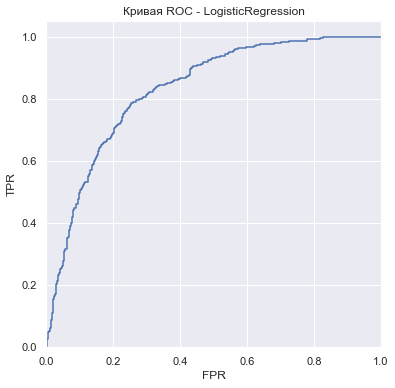

Wall time: 538 ms


In [62]:
%%time

def LogReg(X_train=X_train, X_test=X_test, Y_train = Y_train,  Y_test=Y_test):
    model_logReg = LogisticRegression(class_weight='balanced')
    model_logReg.fit(X_train, Y_train)
    predict_model_logReg = model_logReg.predict(X_test)

    f1_model_logReg = f1_score(Y_test, predict_model_logReg)
    accuracy_model_logReg = accuracy_score(Y_test, predict_model_logReg)

    probabilities = model_logReg.predict_proba(X_test)
    probabilities_one_valid = probabilities[:,1]
    auc_roc_model_logReg = roc_auc_score(Y_test, probabilities_one_valid)

    print('f1_score =', f1_model_logReg)
    print('accuracy =', accuracy_model_logReg)
    print('AUC-ROC =', auc_roc_model_logReg)

    fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
    
    return f1_model_logReg, accuracy_model_logReg, auc_roc_model_logReg, fpr, tpr, thresholds

def fig(fpr,tpr, labels):
    plt.figure(figsize=(6, 6))
    plt.step(fpr, tpr, where='post')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(labels)
    plt.show()
    
f1_model_logReg, accuracy_model_logReg, auc_roc_model_logReg, fpr, tpr, _ = LogReg(X_train=X_train, X_test=X_test, Y_train = Y_train,  Y_test=Y_test)
fig(fpr,tpr, labels = 'Кривая ROC - LogisticRegression')

In [63]:
index_table = 0
table = pd.DataFrame(columns=['name','accuracy','f1_score','AUC-ROC','total_time_in_seconds', 'comment'])
index_table +=1
table.loc[index_table] = ['Logistic Regression', accuracy_model_logReg, f1_model_logReg, auc_roc_model_logReg, 0.1 , 'all features']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.72402,0.615506,0.829486,0.1,all features


### Вывод
Так как логистическая модель одна из самых простых, то результат полученный на данном алгоритме является отправной точкой для всех остальных моделей. Значение AUC-ROC > 0.75, что означает, что данный результат уже выше порога по проекту.

### Протестируем модель на качество при удалении признака `diff`

In [64]:
X_train_1 = X_train.drop(['diff'], axis=1)
X_test_1 = X_test.drop(['diff'], axis=1)

f1_score = 0.6156274664561957
accuracy = 0.7234525837592277
AUC-ROC = 0.8321973385264525


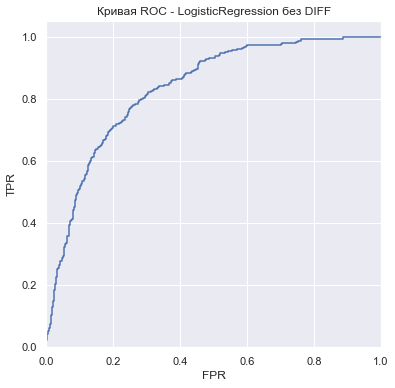

In [65]:
f1_model_logReg, accuracy_model_logReg, auc_roc_model_logReg, fpr, tpr, _ = LogReg(X_train_1, X_test_1, Y_train,  Y_test)
fig(fpr,tpr, labels = 'Кривая ROC - LogisticRegression без DIFF')

In [66]:
index_table +=1
table.loc[index_table] = ['Logistic Regression', accuracy_model_logReg, f1_model_logReg, auc_roc_model_logReg, 0.1 , 'without Diff']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff


### Вывод
На качестве модели отобразилось только десятитысячных долях метрики AUC-ROC, что предполагает незначимость данного признака для модели

### Протестируем модель на качество при удалении признака `diff` и `MonthlyCharges`

f1_score = 0.618933969769292
accuracy = 0.7279954571266326
AUC-ROC = 0.831361325032211


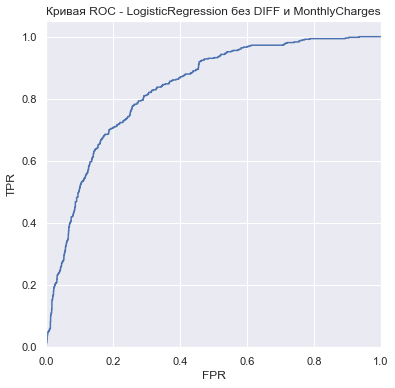

In [67]:
X_train_2 = X_train_1.drop(['MonthlyCharges'], axis=1)
X_test_2 = X_test_1.drop(['MonthlyCharges'], axis=1)

f1_model_logReg, accuracy_model_logReg, auc_roc_model_logReg, fpr, tpr, _ = LogReg(X_train_2, X_test_2, Y_train,  Y_test)
fig(fpr,tpr, labels = 'Кривая ROC - LogisticRegression без DIFF и MonthlyCharges')

In [68]:
index_table +=1
table.loc[index_table] = ['Logistic Regression', accuracy_model_logReg, f1_model_logReg, auc_roc_model_logReg, 0.1 , 'without Diff, MomthyCharges']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"


### Вывод
Качество модели не пострадало, целевая метрика разнится только на 4 знаке после запятой, агрегированная метрика улучшилась на третьем знаке после запятой (f1), Accuracy также разнится на третьем знаке после запятой. Т.о. для дальнейшего обучения берём выборки без diff, MonthyCharges.

### RFC

In [69]:
%%time

rfc = RandomForestClassifier(random_state=12345,class_weight='balanced')

param_grid = {'n_estimators': range(90, 101, 1)\
              #,'max_features': ['auto', 'sqrt', 'log2']\
              ,'max_depth' : range(10, 15, 1),\
              'criterion' : ['gini', 'entropy']\
             }

grid_cv = GridSearchCV(rfc, param_grid, scoring=['f1', 'accuracy', 'roc_auc'], refit='roc_auc', cv=3, verbose=10, n_jobs = -1)

grid_cv.fit(X_train_2, Y_train)
print('\nbest_params_ \n', grid_cv.best_params_)
print('\nbest_score \n', grid_cv.best_score_)

Fitting 3 folds for each of 110 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   


best_params_ 
 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}

best_score 
 0.8261475740119707
Wall time: 1min 31s


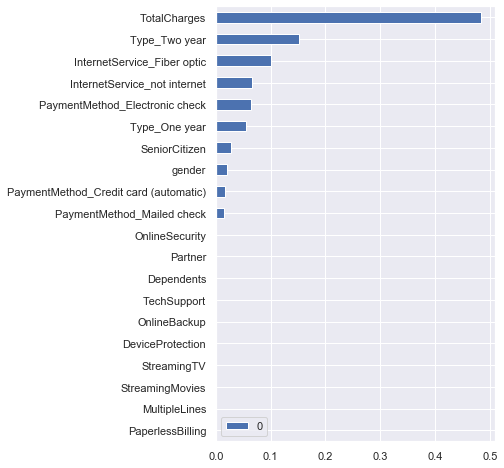

In [70]:
def feature_important(grid_cv, X_train):
    temp = pd.DataFrame(data = grid_cv.best_estimator_.feature_importances_).T
    temp.columns = X_train.columns
    temp.T.sort_values(by=0, ascending=True).plot(kind='barh', figsize=(5,8))
feature_important(grid_cv, X_train_2)

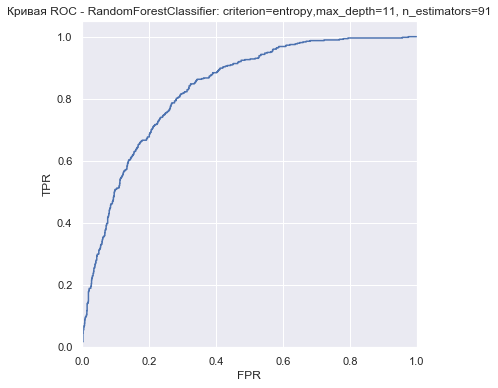

In [71]:
probabilities = grid_cv.predict_proba(X_test_2)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)

fig(fpr,tpr, labels = 'Кривая ROC - RandomForestClassifier: criterion=entropy,max_depth=11, n_estimators=91')


In [72]:
predict_model_rfc = grid_cv.predict(X_test_2)
f1_model_rfc = f1_score(Y_test, predict_model_rfc)
accuracy_model_rfc = accuracy_score(Y_test, predict_model_rfc)

auc_roc_model_rfc = roc_auc_score(Y_test, probabilities_one_valid)

print('f1_score =', f1_model_rfc)
print('accuracy =', accuracy_model_rfc)
print('AUC-ROC =', auc_roc_model_rfc)

f1_score = 0.6208742194469224
accuracy = 0.7586598523566156
AUC-ROC = 0.8329464721869786


In [73]:
index_table +=1
table.loc[index_table] = ['RandomForestClassifier', accuracy_model_rfc, f1_model_rfc, auc_roc_model_rfc, 2, 'without Diff and MonthyCharge']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge


In [74]:
%%time

rfc = RandomForestClassifier(random_state=12345,class_weight='balanced')

param_grid = {'n_estimators': range(90, 102, 1)\
              #,'max_features': ['auto', 'sqrt', 'log2']\
              ,'max_depth' : range(9, 20, 1),\
              'criterion' : ['gini', 'entropy']\
             }

grid_cv = GridSearchCV(rfc, param_grid, scoring=['f1', 'accuracy', 'roc_auc'], refit='roc_auc', cv=3, verbose=10, n_jobs = -1)

grid_cv.fit(X_train, Y_train)
print('\nbest_params_ \n', grid_cv.best_params_)
print('\nbest_score \n', grid_cv.best_score_)

Fitting 3 folds for each of 264 candidates, totalling 792 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   


best_params_ 
 {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 91}

best_score 
 0.8682015938109128
Wall time: 4min 50s


In [75]:
predict_model_rfc = grid_cv.predict(X_test)
f1_model_rfc = f1_score(Y_test, predict_model_rfc)
accuracy_model_rfc = accuracy_score(Y_test, predict_model_rfc)

auc_roc_model_rfc = roc_auc_score(Y_test, probabilities_one_valid)

print('f1_score =', f1_model_rfc)
print('accuracy =', accuracy_model_rfc)
print('AUC-ROC =', auc_roc_model_rfc)

f1_score = 0.676923076923077
accuracy = 0.797274275979557
AUC-ROC = 0.8329464721869786


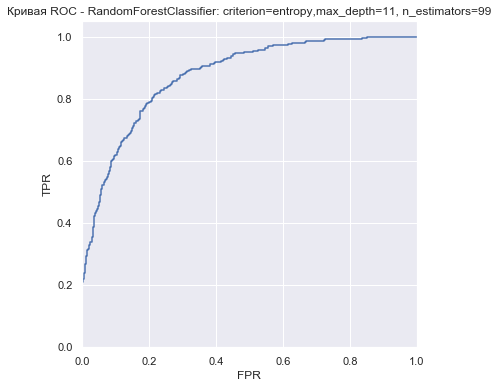

In [76]:
probabilities = grid_cv.predict_proba(X_test)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)

fig(fpr,tpr, labels = 'Кривая ROC - RandomForestClassifier: criterion=entropy,max_depth=11, n_estimators=99')

In [77]:
index_table

4

In [78]:
index_table +=1
table.loc[index_table] = ['RandomForestClassifier', accuracy_model_rfc, f1_model_rfc, auc_roc_model_rfc, 2, 'all features']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge
5,RandomForestClassifier,0.797274,0.676923,0.832946,2.0,all features


### Оценим важность признаков

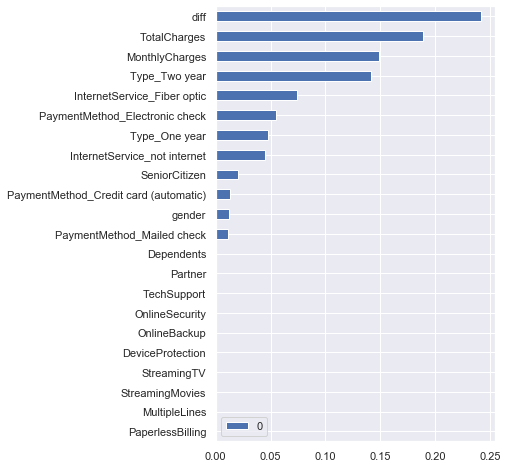

In [79]:
feature_important(grid_cv, X_train)

In [80]:
list(X_train.columns)

['PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'diff',
 'Type_One year',
 'Type_Two year',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'InternetService_Fiber optic',
 'InternetService_not internet']

### Вывод
Результат полученный случайным лесом с тюнингом основных параметров близок к максимальному по проекту, но не хватает 6 десятых процента. Не смотря на полученное значение 0.87 (получено на сете данных без удаления diff и MonthyCharge) время порядка 5 секунд. Признаки: `Dependents`,`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` - можно удалить из модели, так как их вес равен 0, соответственно можно задать вопрос маркетингу о необходимости данных признаков. При удалении коррляционно связанных признаков `MonthlyCharges` и `diff` целевая метрика упала на 3 единицы, что критично в данном случае, возможно требуется для получения результат с удаленными признаками больше деревьев.

### SVM

f1_score = 0.5497512437810945
accuracy = 0.794434980124929
AUC-ROC = 0.8275730364337959


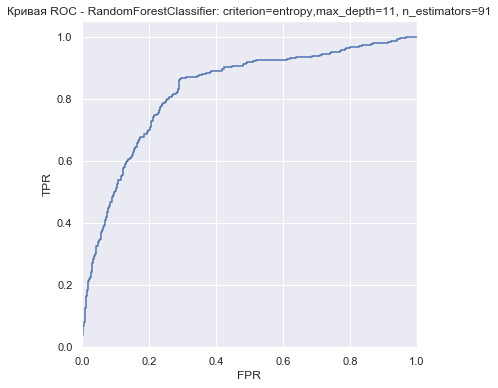

Wall time: 8.72 s


In [81]:
%%time
from sklearn import svm
clf = svm.SVC(probability=True)
clf.fit(X_train, Y_train)
predict_model_clf = clf.predict(X_test)

f1_model_clf = f1_score(Y_test, predict_model_clf)
accuracy_model_clf = accuracy_score(Y_test, predict_model_clf)

probabilities = clf.predict_proba(X_test)
probabilities_one_valid = probabilities[:,1]
auc_roc_model_clf = roc_auc_score(Y_test, probabilities_one_valid)

print('f1_score =', f1_model_clf)
print('accuracy =', accuracy_model_clf)
print('AUC-ROC =', auc_roc_model_clf)

probabilities = clf.predict_proba(X_test)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - RandomForestClassifier: criterion=entropy,max_depth=11, n_estimators=91')
plt.show()

In [82]:
index_table +=1
table.loc[index_table] = ['SVM', accuracy_model_clf, f1_model_clf, auc_roc_model_rfc, 7, 'all features']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge
5,RandomForestClassifier,0.797274,0.676923,0.832946,2.0,all features
6,SVM,0.794435,0.549751,0.832946,7.0,all features


### Вывод
Метод опорных векторов в данном случае даёт результат на равне со случайным лесом, но т.к. f1 ниже по сравнению со случайным лесом и логической регресией.

### SGDClassifier

f1_score = 0.6087649402390438
accuracy = 0.7211811470755253
AUC-ROC = 0.8277500745855176


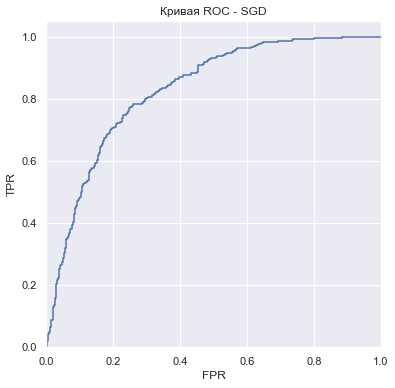

In [83]:
sgd = SGDClassifier(verbose=0, random_state=12345, n_jobs=-1, class_weight='balanced', loss='hinge')
sgd.fit(X_train,Y_train)

predict_model_sgd = sgd.predict(X_test)

f1_model_sgd = f1_score(Y_test, predict_model_sgd)
accuracy_model_sgd = accuracy_score(Y_test, predict_model_sgd)

calibrator_sgd = CalibratedClassifierCV(sgd, cv='prefit')
model=calibrator_sgd.fit(X_train,Y_train)

probabilities = model.predict_proba(X_test)
probabilities_one_valid = probabilities[:,1]
auc_roc_model_sgd = roc_auc_score(Y_test, probabilities_one_valid)

print('f1_score =', f1_model_sgd)
print('accuracy =', accuracy_model_sgd)
print('AUC-ROC =', auc_roc_model_sgd)

fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - SGD')
plt.show()


In [84]:
index_table +=1
table.loc[index_table] = ['SGD', accuracy_model_sgd, f1_model_sgd, auc_roc_model_sgd, 7, 'all features']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge
5,RandomForestClassifier,0.797274,0.676923,0.832946,2.0,all features
6,SVM,0.794435,0.549751,0.832946,7.0,all features
7,SGD,0.721181,0.608765,0.827750,7.0,all features


### Вывод
Результат идентичен логической регресии, отличие только по времени работы

## Вывод
Было исследовано несколько классификаторов, из них logistic regression и SGD дали идентичный результат по метрикам AUC-ROC = 0.83, Accuracy = 0.72 и f1 = 0.61. RandomForestClassifier и SVM  дали максимальный результат по метрикам AUC-ROC = 0.87, Accuracy = 0.79, но по метрике f1 SVM просела до 0.54, а RandomForestClassifier дал напротив максимальный результат 0.67, что означает его более точное и полное предсказаие как 1, так и 0. Лучшая модель RandomForestClassifier. 

#### Целевое значение ROC_AUC достигнуто, но для получения большего значения попробуем устранить дисбаланс вручную

In [85]:
def downsample(x, y):
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    fraction = round((y[y == 1].count() / y[y == 0].count()),2)
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_downsampled = pd.concat([x_zeros.sample(frac=fraction, random_state=12345)] + [x_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    x_downsampled, y_downsampled = shuffle(x_downsampled, y_downsampled, random_state=12345)
    
    return x_downsampled, y_downsampled

fraction = round((target[target == 1].count() / target[target == 0].count()),2)
print(fraction)

#features, target = downsample(features, target, fraction)
#display(features)
#display

0.36


In [86]:
X_train, X_test, Y_train, Y_test = create_sample(features, target)
X_train, Y_train = downsample(X_train, Y_train)
fraction = round((Y_train[Y_train == 1].count() / Y_train[Y_train == 0].count()),2)
print(fraction)

Проверка размера выборок:
X_train (5282, 22)
X_test (1761, 22)
Y_train (5282,)
Y_test (1761,)


,MonthlyCharges,TotalCharges,diff
0,-1.475875,-0.885517,-0.735544
1,0.617064,1.674202,1.608718


,MonthlyCharges,TotalCharges,diff
0,-1.514079,-0.782265,-0.242086
1,0.668557,-0.188889,-0.408375


,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,MultipleLines,diff,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_not internet
4869,1,-1.341329,-1.005327,0,0,1,1,1,1,1,...,1,1,-1.269560,0,0,0,1,0,0,0
4011,1,-0.693515,-0.996717,0,0,1,1,1,1,1,...,1,1,-1.270912,0,0,0,1,0,0,0
4313,1,0.691811,0.061261,1,0,1,1,1,1,1,...,1,1,-0.159618,0,0,0,1,0,1,0
3177,1,1.331320,1.263577,1,1,1,1,1,1,1,...,1,1,0.705623,0,1,1,0,0,1,0
3499,1,-1.480858,-1.007181,1,0,1,1,1,1,1,...,1,1,-1.311470,1,0,0,0,1,0,1


,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,MultipleLines,diff,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_not internet
1745,1,1.050601,1.998375,0,1,1,1,1,1,1,...,1,1,1.608718,0,1,0,0,0,1,0
489,1,1.460883,2.123682,0,1,1,1,1,1,1,...,1,1,1.281549,0,0,0,0,0,1,0
863,1,0.690150,-0.068439,1,0,1,1,1,1,1,...,1,1,-0.282644,0,0,0,1,0,1,0
1741,1,0.203459,0.882048,0,0,1,1,1,1,1,...,1,1,1.035496,1,0,1,0,0,0,0
1542,1,-1.495808,-0.832334,1,0,1,1,1,1,1,...,1,1,-0.486787,0,0,0,0,1,0,1


1.0


f1_score = 0.6152635719905586
accuracy = 0.7223168654173765
AUC-ROC = 0.828987702405424


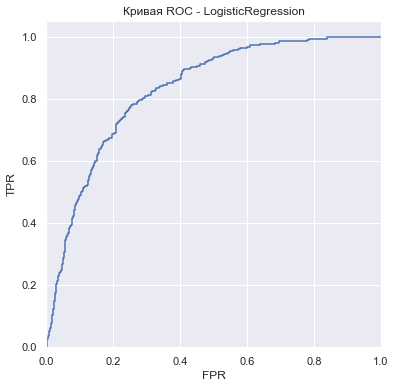

In [87]:
f1_model_logReg, accuracy_model_logReg, auc_roc_model_logReg, fpr, tpr, _ = LogReg(X_train=X_train, X_test=X_test, Y_train = Y_train,  Y_test=Y_test)
fig(fpr,tpr, labels = 'Кривая ROC - LogisticRegression')

In [88]:
index_table +=1
table.loc[index_table] = ['Logistic Regression(Downsample)', accuracy_model_logReg, f1_model_logReg, auc_roc_model_logReg, 2, 'all features']
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge
5,RandomForestClassifier,0.797274,0.676923,0.832946,2.0,all features
6,SVM,0.794435,0.549751,0.832946,7.0,all features
7,SGD,0.721181,0.608765,0.827750,7.0,all features
8,Logistic Regression(Downsample),0.722317,0.615264,0.828988,2.0,all features


In [89]:
fraction = round((Y_train[Y_train == 1].count() / Y_train[Y_train == 0].count()),2)
print(fraction)

1.0


In [90]:
%%time

rfc = RandomForestClassifier(random_state=12345,class_weight='balanced')

param_grid = {'n_estimators': [100, 110, 120]\
              #,'max_features': ['auto', 'sqrt', 'log2']\
              ,'max_depth' : range(10, 12, 1),\
              'criterion' : ['entropy']\
             }

grid_cv = GridSearchCV(rfc, param_grid, scoring=['f1', 'accuracy', 'roc_auc'], refit='roc_auc', cv=3, verbose=10, n_jobs = -1)

grid_cv.fit(X_train, Y_train)
print('\nbest_params_ \n', grid_cv.best_params_)
print('\nbest_score \n', grid_cv.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    4.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    4.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   10.8s finished



best_params_ 
 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 110}

best_score 
 0.85944604087934
Wall time: 12.2 s


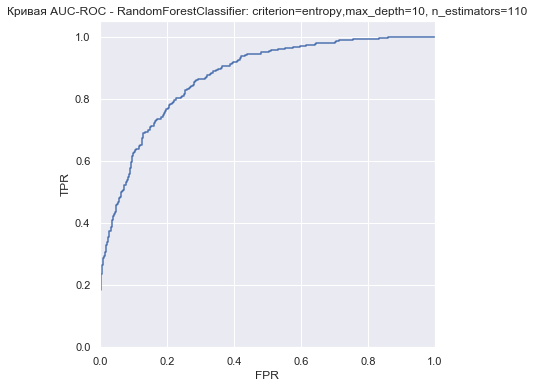

In [91]:
probabilities = grid_cv.predict_proba(X_test)
probabilities_one_valid = probabilities[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)

fig(fpr,tpr, labels = 'Кривая AUC-ROC - RandomForestClassifier: criterion=entropy,max_depth=10, n_estimators=110')

In [92]:
predict_model_rfc = grid_cv.predict(X_test)
f1_model_rfc = f1_score(Y_test, predict_model_rfc)
accuracy_model_rfc = accuracy_score(Y_test, predict_model_rfc)

auc_roc_model_rfc = roc_auc_score(Y_test, probabilities_one_valid)

print('f1_score =', f1_model_rfc)
print('accuracy =', accuracy_model_rfc)
print('AUC-ROC =', auc_roc_model_rfc)

f1_score = 0.654639175257732
accuracy = 0.7717206132879046
AUC-ROC = 0.8705539654906743


In [93]:
table

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge
5,RandomForestClassifier,0.797274,0.676923,0.832946,2.0,all features
6,SVM,0.794435,0.549751,0.832946,7.0,all features
7,SGD,0.721181,0.608765,0.827750,7.0,all features
8,Logistic Regression(Downsample),0.722317,0.615264,0.828988,2.0,all features


In [94]:
#index_table +=1
#table.loc[index_table] = ['RandomForestClassifier(Downsample)', accuracy_model_rfc, f1_model_rfc, auc_roc_model_rfc, 6, 'all features']

table.sort_values(by='AUC-ROC', ascending=False)

,name,accuracy,f1_score,AUC-ROC,total_time_in_seconds,comment
4,RandomForestClassifier,0.758660,0.620874,0.832946,2.0,without Diff and MonthyCharge
5,RandomForestClassifier,0.797274,0.676923,0.832946,2.0,all features
6,SVM,0.794435,0.549751,0.832946,7.0,all features
2,Logistic Regression,0.723453,0.615627,0.832197,0.1,without Diff
3,Logistic Regression,0.727995,0.618934,0.831361,0.1,"without Diff, MomthyCharges"
1,Logistic Regression,0.724020,0.615506,0.829486,0.1,all features
8,Logistic Regression(Downsample),0.722317,0.615264,0.828988,2.0,all features
7,SGD,0.721181,0.608765,0.827750,7.0,all features


# Вывод

Лучший результат по AUC-ROC = 0.87 был достигнут на сете данных без балансировки и с балансировкой с помощью RandomForestClassifier. Следующим этапом необходимо проверить как будет работать модель на сете данных, если удалить признаки получившие веса равные нулю, также необходимо от отдела маркетинга получить информацию о необходимости данных признаков. Т.к. появился ооток клиентов и за 4 месяца он состовил 26 процентов всей клиентской базы, а данные клиенты производили большие месячные траты по сравнению с оставшейся частью базы, в случае если компания не примет меры то за 2020 год потеряет всю клиентскую базу. На основании проведенного анализа можно сделать вывод, что борльшинство новых клиентов, которые пришли в компанию уходят или уйдут в ближайшее время, следует пересмотреть спектр предоставляемых услуг и клиентам которые на основании модели машинного обучения предположительно должны были уйти необходимо предоставить целевое предложение. 


----

# План работы
1. Привести таблицу к формату для работы моделей:
    * Произвести кодировку категориальных переменных
    * Произвести масшабирование признаков оплаты - дискретные значения. 
    * Проверить нет ли сильных корреляционных связей
2. Протестировать основные модели
    * Логическая регрессия
    * Random Forest Classifier
    * SVM
    * Бустинги
3. Выявить наиболее быстрые иснструменты и произвести тюнинг.

---------------

# Отчёт

---------------

* Согласно изначально поставленному плану были сделаны все намеченные шаги кроме использования бустинговых моделей. В данном случае они не потребовались, т.к. логическая регрессия дала результат по метрике AUC-ROC 0.84, а случайный лес дал значение метрики 0.87 (AUC-ROC).

* Основной сложностью в работе был поиск оптимального сета, на основании которго можно получить устойчивый результат. При EDA анализе было обнаруженно, что имеется мультиколлинеарность в признаках, избыточность признаков, дисбаланс классов.  
    * При попытке убрать признаки сильно коррелирующие между собой целевая метрика AUC-ROC упала на несколько единиц, да, это позволит получить более учтойчивую модель, но не позволяет получить локальный максимум, который достпен на основании текущих результатов, поэтому мультиколлинеаные признаки не были удалены. 
    * В процессе обучения случайного леса получил признаки не представляющие никакого значения для моделей, т.е. не влияющие на целевую метрику и предсказательную функцию, на основе чего можно сделать выводы, что данные признаки не несут никакой аналитической значимости и возникает вопрос о их надобности.
    * Дисбаланс классов был равен 3, для устраенния данной проблемы с целью улучшения метрик качества модели и улучшения предсказательной функции была произведенна балансировка классов по принципу Downsample, путем уменьшения объектов (строк сета данных). Данный подход дал результат на модели случайного леса и достигнута максимальная метрика среди всех моделей в данном проекте и равна 0.87.
    
* Ключевыми шагами былы: подготовка сета и обучение с тестированием моделей, корректировка сета и повторное тестирование на моделях которые дали максимальный результат.

* Итоговая модель Random Forest Classifier со следующими параметрами: 
    * критерий = Энтропия;
    * количество деревьев = 110;
    * глубина: 10.
  Целевая метрика качества AUC-ROC равна 0.87, accuracy = 0.78, f1 = 0.67. Три метрики показывают, что результирующая функция предсказания даёт хороший результат. Данная модель была обученна на сбалансированном сете, дя избежания переобучения какого либо класса.



<font color="blue">Отличная шикарная работа.